In [76]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import earth2grid
from earth2grid import healpix
import torch

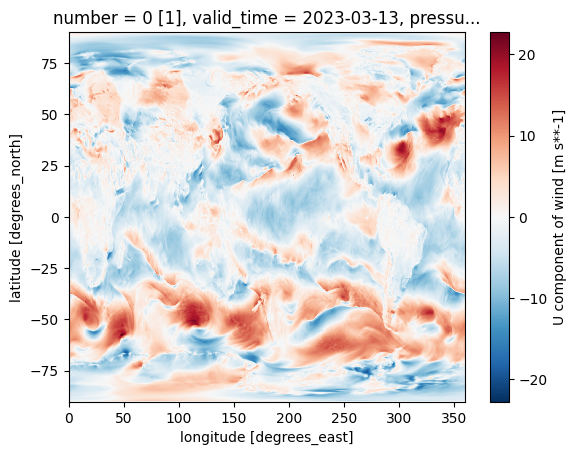

In [28]:
da = xr.open_dataset('era5_20230313_wind.nc').isel(valid_time=0).isel(pressure_level=0)['u']
da.plot()
plt.show()

Let's first reorder our lat/lon data to HEALPix ring ordering. This ordering is the convention in other fields and orders pixels by latitude as shown below.

![alt text](image.png)

In [30]:
src_grid = earth2grid.latlon.equiangular_lat_lon_grid(len(da.latitude), len(da.longitude))

nside = 64
level = int(np.log2(nside))
hpx_ring_grid = earth2grid.healpix.Grid(level=level, pixel_order=earth2grid.healpix.PixelOrder.RING)
regrid_to_ring = earth2grid.get_regridder(src_grid, hpx_ring_grid)

In [31]:
out = regrid_to_ring(torch.tensor(da.data).double())

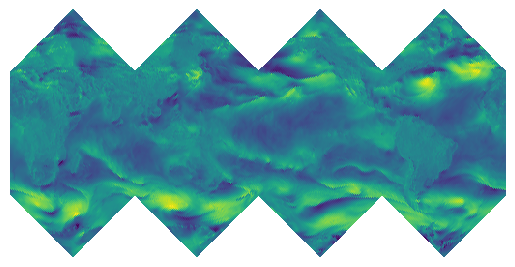

In [32]:
earth2grid.healpix.pcolormesh(out)

Unfortunately, ring ordering is not very convenient for usage with CNNs. Instead, we'll use XY face ordering which separates each of the 12 HEALPix faces in distinct "images". This way, we can process each individually with our CNN and pad each face using its neighbor.

![alt text](image-1.png)

In [39]:
nside = 64
level = int(np.log2(nside))
hpx_xy_grid = earth2grid.healpix.Grid(level=level, pixel_order=earth2grid.healpix.XY(origin=earth2grid.healpix.Compass.N, clockwise=True))
regrid_to_xy = earth2grid.get_regridder(src_grid, hpx_xy_grid)

In [41]:
faces = regrid_to_xy(torch.tensor(da.data).double())
faces = faces.reshape(12,64,64)

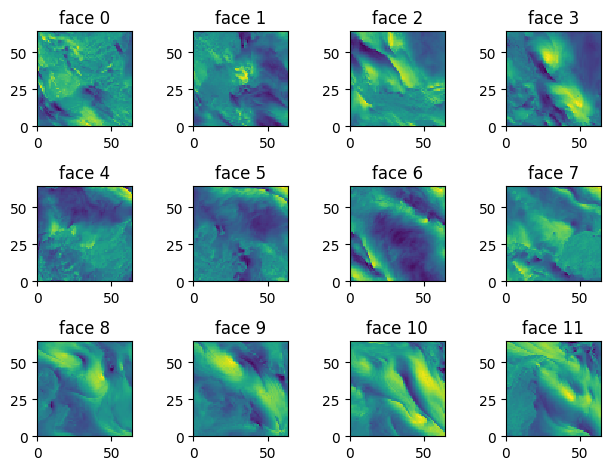

In [42]:
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.pcolormesh(faces[i])
    plt.gca().set_aspect('equal')
    plt.title(f'face {i}')
plt.tight_layout()

Let's write a function to pad a northern hemisphere HEALPix face using its neighbors!

![alt text](image-2.png)
![alt text](image-3.png)

In [64]:
n1, n2, n3, n4, e1, e2, e3, e4, s1, s2, s3, s4 = faces

In [ ]:
def pad_n2(n2, n1, n3, n4, e2, e3, s2, pad=1):
    pass


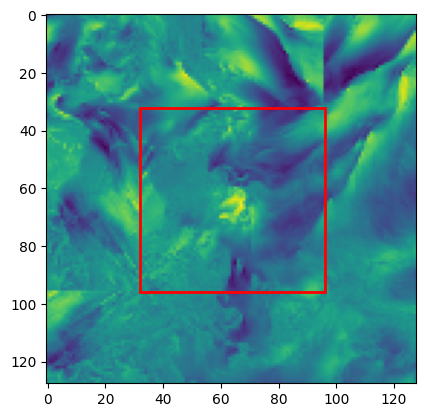

In [ ]:
pad = 32
n2_padded = pad_n2(n2, n1, n3, n4, e2, e3, s2, pad=pad)
plt.imshow(n2_padded)

rect = patches.Rectangle((pad,pad), nside, nside, linewidth=2, edgecolor='r', facecolor='none')
plt.gca().add_patch(rect)
plt.gca().set_aspect('equal')

plt.show()